In [682]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

In [683]:
#CARGAMOS LAS IMAGENES NECESARIAS 
yosemite1 = cv.imread('datos-T2/yosemite/Yosemite1.jpg')
yosemite2 = cv.imread('datos-T2/yosemite/Yosemite2.jpg')

#AJUSTAMOS PARAMETROS
yosemite1_edgeThreshold = 10
yosemite2_edgeThreshold = 10
yosemite1_contrastThreshold = 0.04
yosemite2_contrastThreshold = 0.04
yosemite1_hessianThreshold = 100
yosemite2_hessianThreshold = 100

## EJERCICIO 1
** Detección de puntos SIFT y SURF. Aplicar la detección de puntos SIFT y SURF sobre las imágenes, representar dichos puntos sobre las imágenes haciendo uso de la función drawKeyPoints. Presentar los resultados con las imágenes Yosemite.rar. **

In [684]:
def mapOctaves(keyPoints: list) -> list:
    kp_octaves = {}

    for kp in keyPoints:
        if not str(kp.octave) in kp_octaves:
            kp_octaves[str(kp.octave)] = []

        kp_octaves[str(kp.octave)].append(kp)

    return kp_octaves

In [685]:
def colorAt(octave: int) -> list:
    base = int(octave) % (256*256*256)


    r = base % 256
    g = (base // 256) % 256
    b = (base // (256*256)) % 256
    
    return (b,g,r)

a) Variar los valores de umbral de la función de detección de puntos
hasta obtener un conjunto numeroso ($\leq$ 1000) de puntos SIFT y
SURF que sea representativo de la imagen. Justificar la elección
de los parámetros en relación a la representatividad de los puntos
obtenidos.

En primer lugar vamos a abordar el problema de deteccion de puntos SIFT (__Scalable Invariance Feature Transform__)

SIFT tiene dos mecanismos para descartar __KeyPoints__: por contraste o por respuesta del gradiente. Veamos en que consiste cada uno:

__Por Contraste__: Comparando el pixel con cada uno de sus vecinos, es posible ver si el contraste es bajo.
Para esto Matthew Brown desarrolló un método que consiste en ajustar una función cuadrática a los __KeyPoints__ obtenidos $(x,y,\sigma)$. Brown utiliza la serie de Taylor hasta el termino cuadŕatico.

\begin{align}
D(x) = D + \frac{\partial D^T}{\partial x} x + \frac{1}{2}x^T\frac{\partial^2 D}{\partial x^2} x
\end{align}

donde x = $(x,y,\sigma) ^T$, los mejores puntos serán los que correspondan a los máximos de la función, por tanto, derivamos e igualamos a cero.

\begin{align}
\hat{x} = - \frac{\partial^2 D^{-1}}{\partial x^2} \frac{\partial D}{\partial x}
\end{align}


$\hat{x}$ se corresponde con los mejores puntos. Ahora aplicamos la función de coste a cada punto para poder descartar los puntos con bajo contraste.

\begin{align}
D(\hat{x}) = D + \frac{1}{2} \frac{\partial D^T}{\partial x} \hat{x}
\end{align}

Los puntos que no superen un determinado valor, serán descartados. David G. Lowe llegó a la conclusión de que este valor era 0.03 (OpenCV toma este valor como 0.04)

En el código de esta práctica, este valor viene dado por la variable 'contrastThreshold'

__Por respuesta del gradinte__: Para esto, tomamos la aproximación de Harris y Stephens.

Calculamos la matriz Hessiana $H$ en cada $\hat{x}$. A continuación calculamos los autovalores y autovectores de $H$.

Los autovectores representan las direcciones que toma el gradinte en el eje de la X y de las Y en ese punto.
Los  autovalores estan asociados a estos autovectores.

Sea $\alpha$ el autovalor mas grande y $\beta$ el más pequeño. Vamos a imponer la siguiete condición

\begin{align}
\alpha < r\beta
\end{align}

Volviendo a la aproximación de Harris y Stephens obtenemos,

\begin{align}
\frac{Th(H)^2}{DetH}=\frac{(\alpha + \beta)^2}{\alpha\beta}
\end{align}

Añadiendo la condición impoesta tenemos,

\begin{align}
\frac{Th(H)^2}{DetH}<\frac{(1 + r)^2}{r}
\end{align}

Todos aquelles __KeyPoints__ que nos superen esta condición serán descartados.  David G. Lowe llegó a la conclusión de que este valor 10.

En el código de esta práctica, este valor viene dado por la variable 'edgeThreshold'

In [686]:
def drawSiftImg(src: np.ndarray, contrastThreshold: float, edgeThreshold: int) -> list:
    #CONVERTIMOS LA IMAGEN A ESCALA DE GRISES
    src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
        
    #Definimos el detector de puntos SIFT
    sift = cv.xfeatures2d.SIFT_create(0, 3, contrastThreshold, edgeThreshold, 1.6)
    
    #Detectamos puntos SIFT sobre 'src_gray' utilizando el detector 'sift' y calculamos sus descriptores
    src_kp = sift.detect(src_gray,None)
    src_kp, src_descriptor = sift.compute(src_gray, src_kp, None)


    return (src_kp, src_descriptor)


## DETECTOR SURF

In [687]:
def drawSurfImg(src: np.ndarray, hessianThreshold: int) -> list:
    #CONVERTIMOS LA IMAGEN A ESCALA DE GRISES
    src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)

    #Definimos el detector de puntos SIFT
    surf = cv.xfeatures2d.SURF_create(hessianThreshold = hessianThreshold)

    #Detectamos puntos SIFT sobre 'src_gray' utilizando el detector 'surf' y calculamos sus descriptores
    src_kp = surf.detect(src_gray, None)
    src_kp, src_descriptor = surf.compute(src_gray, src_kp,None)
    


    return (src_kp, src_descriptor)

b) Identificar cuántos puntos se han detectado dentro de cada octava. En el caso de SIFT, identificar también los puntos detectados en cada capa. Mostrar el resultado dibujando sobre la imagen original un cı́rculo centrado en cada punto y de radio proporcional al valor de sigma usado para su detección (ver circle()) y pintar cada octava en un color.

In [688]:
def drawPerOctave(src: np.ndarray, keyPoints: list) -> list:
    dst = np.copy(src)
    mapKeyPointsOctaves = mapOctaves(keyPoints)
    
    for octave, points in mapKeyPointsOctaves.items():
        dst=cv.drawKeypoints(dst,points,dst,colorAt(octave))
        
    return dst

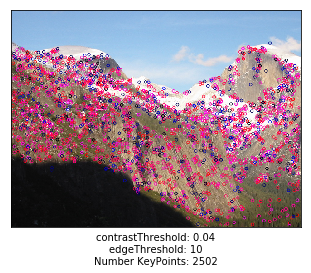

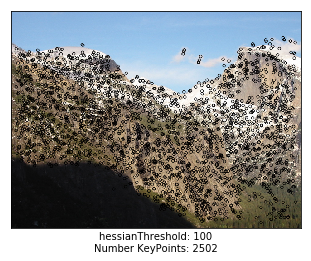

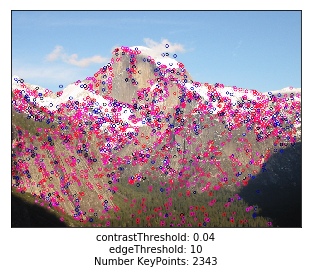

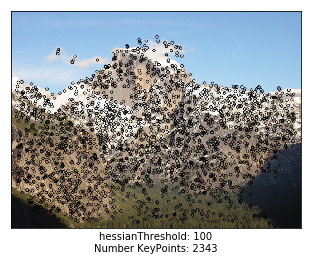

In [689]:
def Ejercicio1(src: np.ndarray, contrastThreshold: float, edgeThreshold: int, hessianThreshold: int) -> list:
    
    (sift_kp, sift_descriptor) = drawSiftImg(src, contrastThreshold, edgeThreshold)
    (surf_kp, surf_descriptor) = drawSurfImg(src, hessianThreshold)

    sift_dst = drawPerOctave(src, sift_kp)
    surf_dst = cv.drawKeypoints(src, surf_kp, src, (0,0,1))
    
    sift_dst = cv.cvtColor(sift_dst, cv.COLOR_BGR2RGB)
    surf_dst = cv.cvtColor(surf_dst, cv.COLOR_BGR2RGB)

    sift_txt = "contrastThreshold: " + str(contrastThreshold)
    sift_txt += "\nedgeThreshold: " + str(edgeThreshold)
    sift_txt += "\nNumber KeyPoints: " + str(len(sift_kp))
    plt.imshow(sift_dst)
    plt.axis('image')
    plt.xticks([])
    plt.yticks([])
    plt.text(320, 560, sift_txt, ha='center')
    plt.show()

 
    surf_txt = "hessianThreshold: " + str(hessianThreshold)
    surf_txt += "\nNumber KeyPoints: " + str(len(sift_kp))
    plt.imshow(surf_dst)
    plt.axis('image')
    plt.xticks([])
    plt.yticks([])
    plt.text(320, 532, surf_txt, ha='center')
    plt.show()
    
    return (sift_kp, sift_descriptor, surf_kp, surf_descriptor)

combo_yosemite1 = Ejercicio1(yosemite1, yosemite1_contrastThreshold, yosemite1_edgeThreshold, yosemite1_hessianThreshold)
combo_yosemite2 = Ejercicio1(yosemite2, yosemite2_contrastThreshold, yosemite2_edgeThreshold, yosemite2_hessianThreshold)



c) Mostrar cómo con el vector de keyPoint extraı́dos se pueden calcular los descriptores SIFT y SURF asociados a cada punto usando OpenCV.

OpenCV posee la funcion compute, cuya cabezera es:
\begin{align}
keypoints, descriptors	=	cv.Feature2D.compute(	image, keypoints\left[, descriptors\right]	)
\end{align}

Esta función, calcula los descriptores desde la imagen y los keyPoints, los keyPoints cuyos descriptores no se pueden calcular son eliminados.

# Ejercicio 2
**Usar el detector-descriptor SIFT de OpenCV sobre las imágenes de Yosemite.rar (cv2.xfeatures2d.SIFT create()). Extraer sus listas de keyPoints y descriptores asociados. Establecer las correspondencias existentes entre ellos usando el objeto BFMatcher de OpenCV y los criterios de correspondencias “BruteForce+crossCheck y “Lowe-Average-
2NN”. (NOTA: Si se usan los resultados propios del puntos anterior en lugar del cálculo de SIFT de OpenCV se añaden 0.5 puntos)**

a) Mostrar ambas imágenes en un mismo canvas y pintar lı́neas de diferentes colores entre las coordenadas de los puntos en correspondencias. Mostrar en cada caso 100 elegidas aleatoriamente.

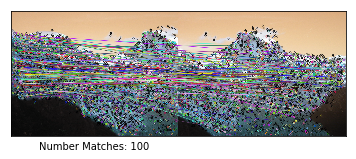

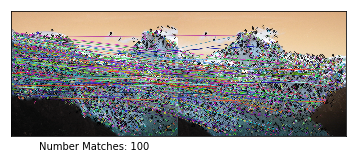

In [690]:
def DrawCorrespondenciesBF(src1, src2, kp1, des1, kp2, des2, nMatches) -> np.ndarray:
    #Definimos un matcher de fuerza bruta
    matcher = cv.BFMatcher_create(crossCheck = 1)
    
    #Establecemos los match
    matches = matcher.match(des1, des2)
        
    #Dibujamos las correspondncias entre matches
    dst = cv.drawMatches(src1, kp1, src2, kp2, matches[:nMatches], None)
    
    return (dst, matches)

def DrawCorrespondenciesAVG(src1, src2, kp1, des1, kp2, des2, nMatches, k) -> np.ndarray:
    #Definimos un matcher de k vecino
    matcher = cv.FlannBasedMatcher()
    
    #Establecemos los match
    matches = matcher.knnMatch(des1, des2, k)
    
    good = []

    for m,n in matches:
        good.append(m)
        
    #Dibujamos las correspondncias entre matches
    dst = cv.drawMatches(src1, kp1, src2, kp2, good[:nMatches], None)
    
    return (dst, matches)


def Ejercicio2(src1, src2, kp1, des1, kp2, des2, nMatches = 100):
    (dst_bf, matches_dst_bf) = DrawCorrespondenciesBF(src1, src2, kp1, des1, kp2, des2, nMatches)
    (dst_avg, matches_dst_avg) = DrawCorrespondenciesAVG(src1, src2, kp1, des1, kp2, des2, nMatches, 2)
    
    txt = "\nNumber Matches: " + str(nMatches)
    plt.imshow(dst_bf)
    plt.axis('image')
    plt.xticks([])
    plt.yticks([])
    plt.text(320, 532, txt, ha='center')
    plt.show()
    
    txt = "\nNumber Matches: " + str(nMatches)
    plt.imshow(dst_avg)
    plt.axis('image')
    plt.xticks([])
    plt.yticks([])
    plt.text(320, 532, txt, ha='center')
    plt.show()
    
Ejercicio2(yosemite1, yosemite2, combo_yosemite1[0], combo_yosemite1[1], combo_yosemite2[0], combo_yosemite2[1])

b) Valorar la calidad de los resultados obtenidos en términos de las correspondencias válidas observadas por inspección ocular y las tendencias de las lı́neas dibujadas.

c) Comparar ambas técnicas de correspondencias en términos de la calidad de sus correspondencias (suponer 100 aleatorias e inspección visual).